         data             op        size
0       5.422          write    0.003906
1       5.427          write    0.003906
2       4.979          write    0.003906
3       5.059          write    0.003906
4       5.574          write    0.003906
...       ...            ...         ...
18013  13.475          write  399.000000
18014  12.764          write  399.000000
18015  12.880          write  399.000000
18016  71.382          write  399.000000
18017  75.000  read_capacity  399.000000

[18018 rows x 3 columns]
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
4.0
7.0
13.0
25.0
49.0
75.0
[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 399.0]


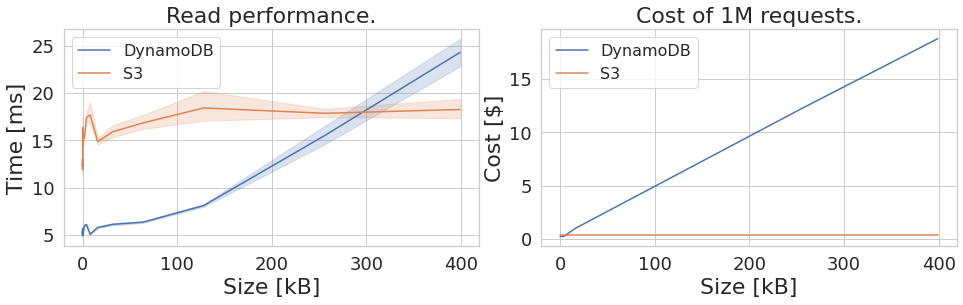

In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

DATA_DIR = join(pardir, pardir, 'data', 'read')

sns.set(rc={'figure.figsize':(16,4)})
sns.set_style("whitegrid")

fig, axes = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0.15)

# DynamoDB
key_value = pd.read_csv(join(DATA_DIR, 'key_value.csv'), index_col=0)
persistent = pd.read_csv(join(DATA_DIR, 'persistent.csv'), index_col=0)
key_value['data'] /= 1000.0
persistent['data'] /= 1000.0
key_value['size'] /= 1024.0
persistent['size'] /= 1024.0

print(key_value)

sns.lineplot(data=key_value.loc[key_value['op'] == 'write'], x='size', y='data', ax=axes[0], label='DynamoDB')#,fontsize=20)
sns.lineplot(data=persistent.loc[persistent['op'] == 'read'], x='size', y='data', ax=axes[0], label='S3')#,fontsize=20)
axes[0].legend(fontsize=16)

# DynamoDB
dynamodb_r_cost = 0.25 / 10**6
dynamodb_cost = []
for s in sizes:
    c = key_value.loc[(key_value['op'] == 'read_capacity') & (key_value['size'] == s)]['data'].values[0]
    print(c)
    dynamodb_cost.append(c * requests * dynamodb_r_cost)
sns.lineplot(x=sizes, y=dynamodb_cost, ax=axes[1], label='DynamoDB')

# S3 cost
requests = 10**6
# price for 1K requests
request_cost = 0.0004 / 1000.0
sizes = key_value['size'].unique().tolist()
s3_cost = [request_cost * requests for x in sizes]
print(sizes)
sns.lineplot(x=sizes, y=s3_cost, ax=axes[1], label='S3')
axes[1].legend(fontsize=16)


#locs = [2 ** i for i in range(2, 20)]
#axes[0].xaxis.set_major_locator(ticker.FixedLocator(locs))
#axes[0].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
#axes[0].set_ylim(0, 410)
#axes[1].set_ylim(0, 410)
axes[0].set_xlabel('Size [kB]',fontsize=22)
axes[1].set_xlabel('Size [kB]',fontsize=22)
axes[0].set_ylabel('Time [ms]',fontsize=22)
axes[1].set_ylabel('Cost [$]',fontsize=22)
axes[0].set_title('Read performance.', fontsize=22)
axes[1].set_title('Cost of 1M requests.', fontsize=22)
axes[0].tick_params(axis='x', labelsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[1].tick_params(axis='x', labelsize=18)
axes[1].tick_params(axis='y', labelsize=18)

#axes[1].annotate('Penalty on cross\nregion access.', xy=(300, 210),
#            xytext=(200, 80), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)
#axes[1].annotate('', xy=(300, 30),
#            xytext=(300, 80), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)
#axes[1].annotate('Slow writes on large\n(user) data.', xy=(300, 300),
#            xytext=(0, 230), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)

#axes[0].annotate('Penalty on cross region access.', xy=(490, 380),
#            xytext=(0, 300), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            #ha='left'
#)
#axes[0].annotate('Efficient read and write\non large user data.', xy=(400, 100),
#            xytext=(150, 125), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)

#handles, labels = axes[1].get_legend_handles_labels()
#axes[1].legend(handles, labels, ncol=5, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)


#ax.set_title('1M read (solid) and\nwrite (dotted) operations.', fontsize=22)
#axes[0].plot(,yrange,color='green',linestyle='solid', label='AWS S3', linewidth=4)

plt.savefig("performance_plot.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

        data  native_data             op        size
0      0.859          0.0           read    0.003906
1      0.718          0.0           read    0.003906
2      0.662          0.0           read    0.003906
3      0.607          0.0           read    0.003906
4      1.191          0.0           read    0.003906
...      ...          ...            ...         ...
17012  1.158          0.0           read  256.000000
17013  1.256          0.0           read  256.000000
17014  1.419          0.0           read  256.000000
17015  1.213          0.0           read  256.000000
17016  0.000          NaN  read_capacity  256.000000

[17017 rows x 4 columns]


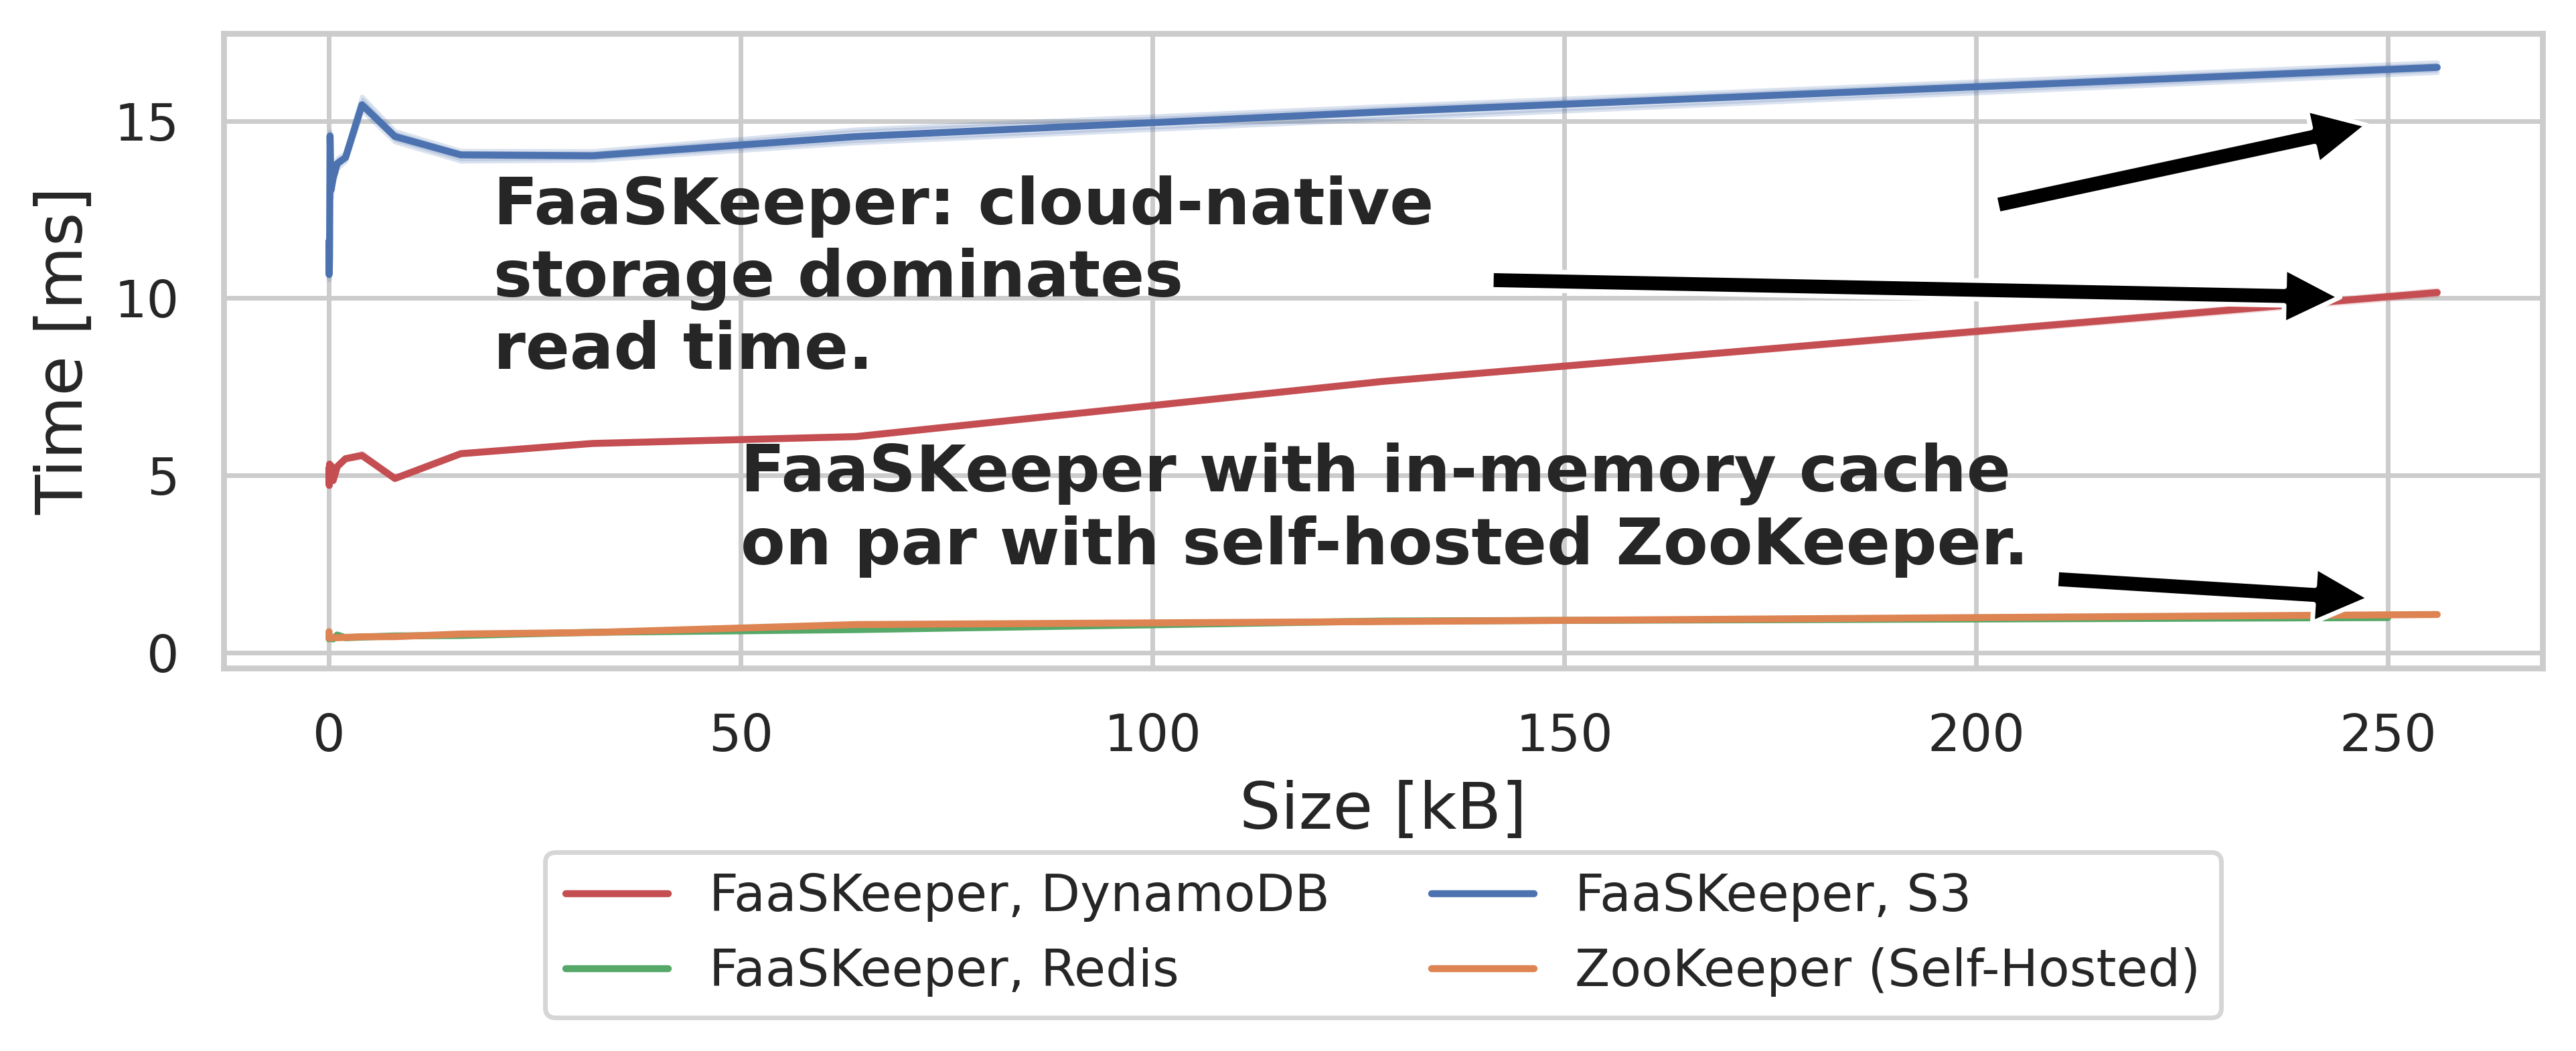

In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

DATA_DIR = join(pardir, pardir, 'data', 'read')

sns.set(rc={'figure.figsize':(8,3.5)})
sns.set_style("whitegrid")

def p50_estimator(x):                                            
    return np.percentile(x, 50)       
def p95_estimator(x):                                            
    return np.percentile(x, 95)         
       

# DynamoDB
key_value = pd.read_csv(join(DATA_DIR, 'key_value.csv'), index_col=0)
redis = pd.read_csv(join(DATA_DIR, 'redis.csv'), index_col=0)
persistent = pd.read_csv(join(DATA_DIR, 'persistent.csv'), index_col=0)
zookeeper = pd.read_csv(join(DATA_DIR, 'zookeeper', 'intrazone.csv'), index_col=0)
key_value['data'] /= 1000.0
redis['data'] /= 1000.0
persistent['data'] /= 1000.0
zookeeper['data'] /= 1000.0
key_value['size'] /= 1024.0
redis['size'] /= 1024.0
persistent['size'] /= 1024.0
zookeeper['size'] /= 1024.0
key_value = key_value.drop(zookeeper[zookeeper['size'] > 256].index)
persistent = persistent.drop(zookeeper[zookeeper['size'] > 256].index)
zookeeper = zookeeper.drop(zookeeper[zookeeper['size'] > 256].index)
print(zookeeper)

sns.lineplot(
    data=key_value.loc[key_value['op'] == 'write'], x='size', y='data', color='r',
    estimator=p50_estimator, label='FaaSKeeper, DynamoDB')#,fontsize=20)

sns.lineplot(
    data=redis.loc[redis['op'] == 'read'], x='size', y='data', color='g',
    estimator=p50_estimator, label='FaaSKeeper, Redis')#,fontsize=20)

ax = sns.lineplot(data=persistent.loc[persistent['op'] == 'read'], x='size', y='data',
                  estimator=p50_estimator, label='FaaSKeeper, S3')#,fontsize=20)
#sns.lineplot(
#    data=key_value.loc[key_value['op'] == 'write'], x='size', y='data', color='r',linestyle='--',
#    estimator=p95_estimator, label='DynamoDB (Cloud)')#,fontsize=20)
sns.lineplot(data=zookeeper.loc[zookeeper['op'] == 'read'], x='size', y='data',
             estimator=p50_estimator, label='ZooKeeper (Self-Hosted)')#,fontsize=20)
#sns.lineplot(data=zookeeper.loc[zookeeper['op'] == 'read'], x='size', y='data', estimator=p95_estimator, label='ZooKeeper (Self-Hosted)',linestyle='--')#,fontsize=20)


ax.set_xlabel('Size [kB]',fontsize=14)
ax.set_ylabel('Time [ms]',fontsize=14)
#ax.set_title('Read performance.', fontsize=22)
#ax.tick_params(axis='x', labelsize=18)
#ax.tick_params(axis='y', labelsize=18)
#ax.set_xlim(0, 400)

#axes[1].annotate('Penalty on cross\nregion access.', xy=(300, 210),
#            xytext=(200, 80), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)
#axes[1].annotate('', xy=(300, 30),
#            xytext=(300, 80), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)
#axes[1].annotate('Slow writes on large\n(user) data.', xy=(300, 300),
#            xytext=(0, 230), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)

#axes[0].annotate('Penalty on cross region access.', xy=(490, 380),
#            xytext=(0, 300), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            #ha='left'
#)
#axes[0].annotate('Efficient read and write\non large user data.', xy=(400, 100),
#            xytext=(150, 125), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)

#handles, labels = axes[1].get_legend_handles_labels()
#axes[1].legend(handles, labels, ncol=5, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)


#ax.set_title('1M read (solid) and\nwrite (dotted) operations.', fontsize=22)
#axes[0].plot(,yrange,color='green',linestyle='solid', label='AWS S3', linewidth=4)


ax.annotate('FaaSKeeper: cloud-native\nstorage dominates\nread time.',
            xy=(250, 10), xytext=(20,8), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05)
)
ax.annotate('',
            xy=(250, 15), xytext=(200,12.5), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05)
)

ax.annotate('FaaSKeeper with in-memory cache\non par with self-hosted ZooKeeper.',
            xy=(250, 1.5), xytext=(50, 2.5), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05)
)

#plt.legend(loc=5)#, bbox_to_anchor=(0,-0.5))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()

plt.savefig("performance_plot_new.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)